In [1]:
#imports
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt
import pandas as pd #dataframes
import cv2
import PIL 
import glob #for getting list of files in a directory
import os #for file paths
import scipy
import skimage
from skimage import io
import seaborn as sns
import seaborn_image as isns

# Feature Exploration


## Histograms and Statistics by Wavelength/Material

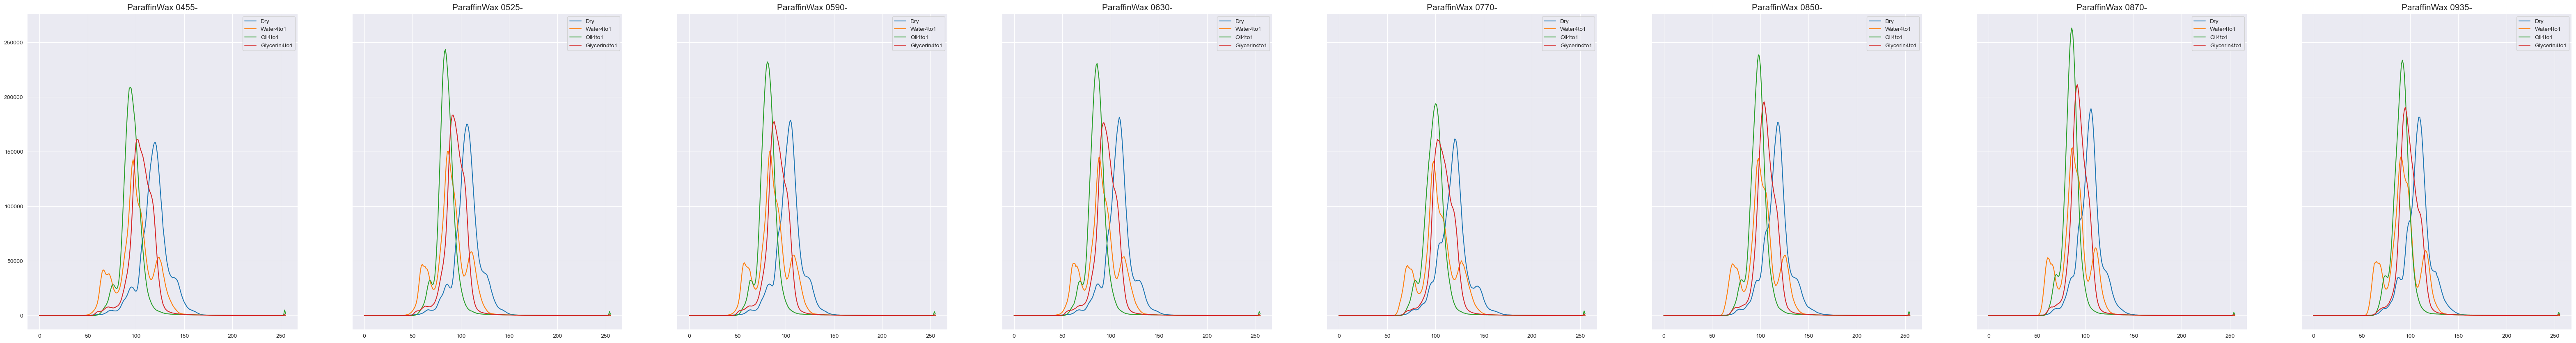

In [30]:
#Histograms to scale

# Input the material to be analyzed
material = "ParaffinWax"

#Input the path to the SandImages folder on your machine
base = '/Users/fanjx1/Documents/SandImages'


#Returns a list of all the wavelengths found inside a path
def wavelengthList(search):
     wavelengths = []
     addresses = glob.glob(search)
     for address in addresses:
          wavelengths.append(os.path.basename(address))
     return [*np.unique(wavelengths)]


def ioOpen(imageFile):
    return io.imread(imageFile)


def createHistogram(ax_number, image, label, title):
     axes = ax_number.plot(pd.DataFrame(PIL.Image.open(image).histogram()), label = label)
     ax_number.legend(loc='best')
     axs[axsCount].set_title(title)
     return axes


# def statList(imageArray):
#     return [round(np.mean(imageArray, axis=(0, 1)),2),
#             round(np.std(imageArray, axis=(0, 1)),2),
#             scipy.stats.median_abs_deviation(imageArray, axis = (0,1)),
#             round(scipy.stats.kurtosis(imageArray, axis = (0,1)),2),
#             round(scipy.stats.skew(imageArray, axis = (0,1)),2)]


#Searching for all wavelengths that a material was imaged in
searchPath = os.path.join(base, 'Composites', '*' + material + '*', '*')
wavelengths = wavelengthList(searchPath)

fig, axs = plt.subplots(1,len(wavelengths), figsize = ((len(wavelengths)*10),10), sharey = True)
axsCount = 0
stats = {}

#A combination is a material (walnut shell/glass beads/anthracite...) and condition (dry/water/oil...)
#This loop finds all the combinations for the selected material in each wavelength, overlays the histograms on a plot and
#displays the histogram statistics below each plot
for wavelength in wavelengths: #wavelength is '.../Material-ConditionRatio/Wavelength-.tiff', etc
     combinationsInWavelength = glob.glob(os.path.join(base,'Composites', '*' + material + '*','*' + wavelength + '*'))
     wavelengthName = wavelength.partition('.')[0]#'0455-'
     materialWavelength = material + " " + wavelengthName #'WalnutShell 0455-'


     for combination in combinationsInWavelength:
          combName = os.path.basename(os.path.dirname(combination)) #'WalnutShell-MineralOil4to1'
          combSplit = combName.partition('-') #['WalnutShell','-','MineralOil4to1']
          createHistogram(axs[axsCount], combination, combSplit[2], materialWavelength)
     #      stats[combSplit[2]] = statList(ioOpen(combination)) #{'Dry' : [100, 20, 2, 17, 2], 'Water' : [60, 12, 4, 39, 1]...}

     # statComparison = pd.DataFrame(stats, index = ['Mean', 'Std Dev', 'MAD', 'Kurt', 'Skew']) #Rows are stat names, columns are conditions

     # wavelengthStats = mpl.table.table(axs[axsCount],
     #                 cellText= statComparison.values,
     #                 colLabels = statComparison.columns,
     #                 rowLabels = statComparison.index,
     #                 bbox = (0.1,-0.3,0.8,0.2))
     # wavelengthStats.auto_set_font_size(False)
     # wavelengthStats.set_fontsize(10)
     # stats.clear()
     axsCount += 1


plotName = material + 'Histogram.png'
if os.path.exists(os.path.join(base, 'ImageStatistics', combSplit[0])) == False:
     os.mkdir(os.path.join(base, 'ImageStatistics', combSplit[0]))
fig.savefig(os.path.join(base, 'ImageStatistics', combSplit[0], plotName), bbox_inches= 'tight')

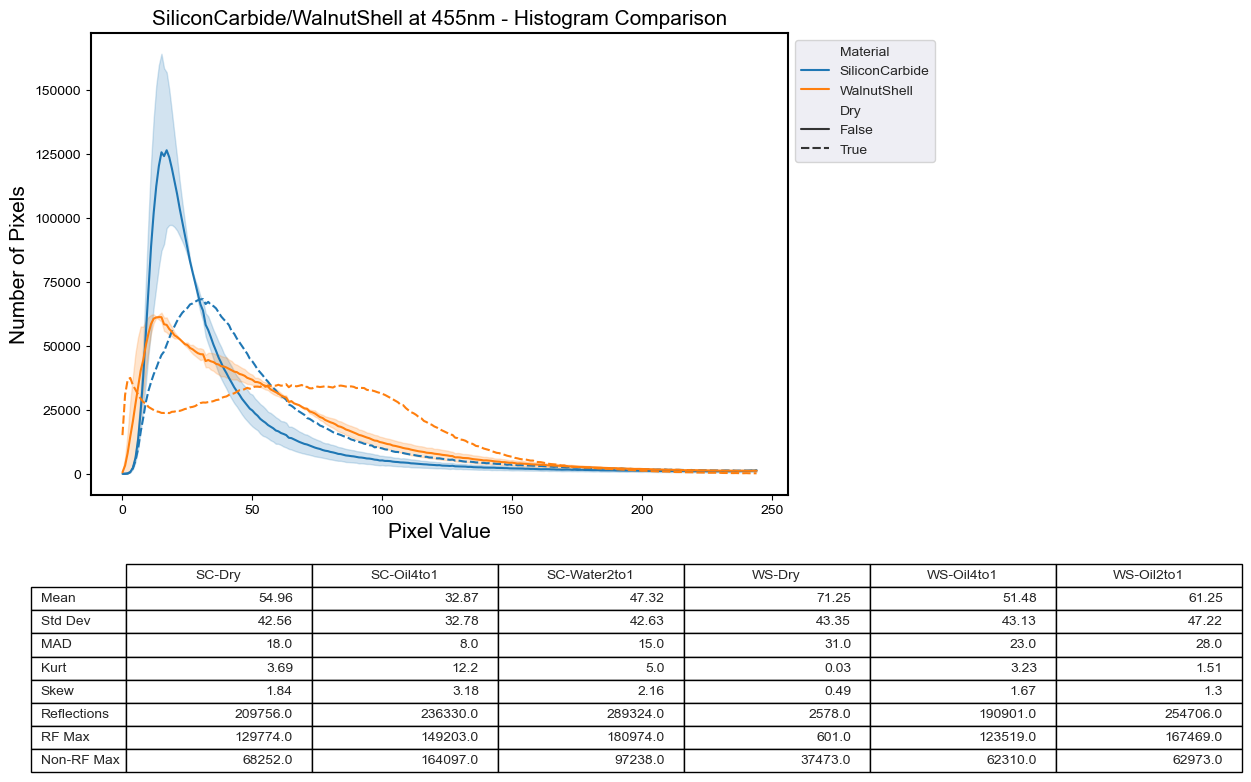

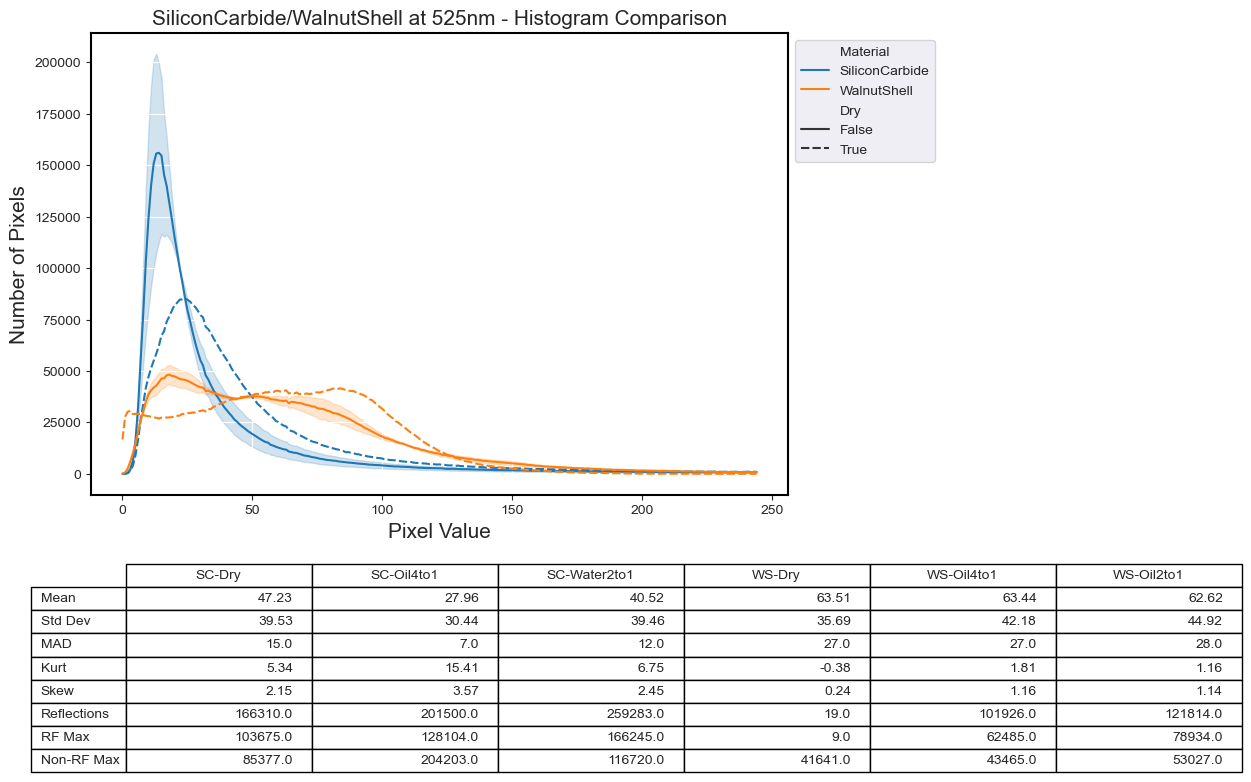

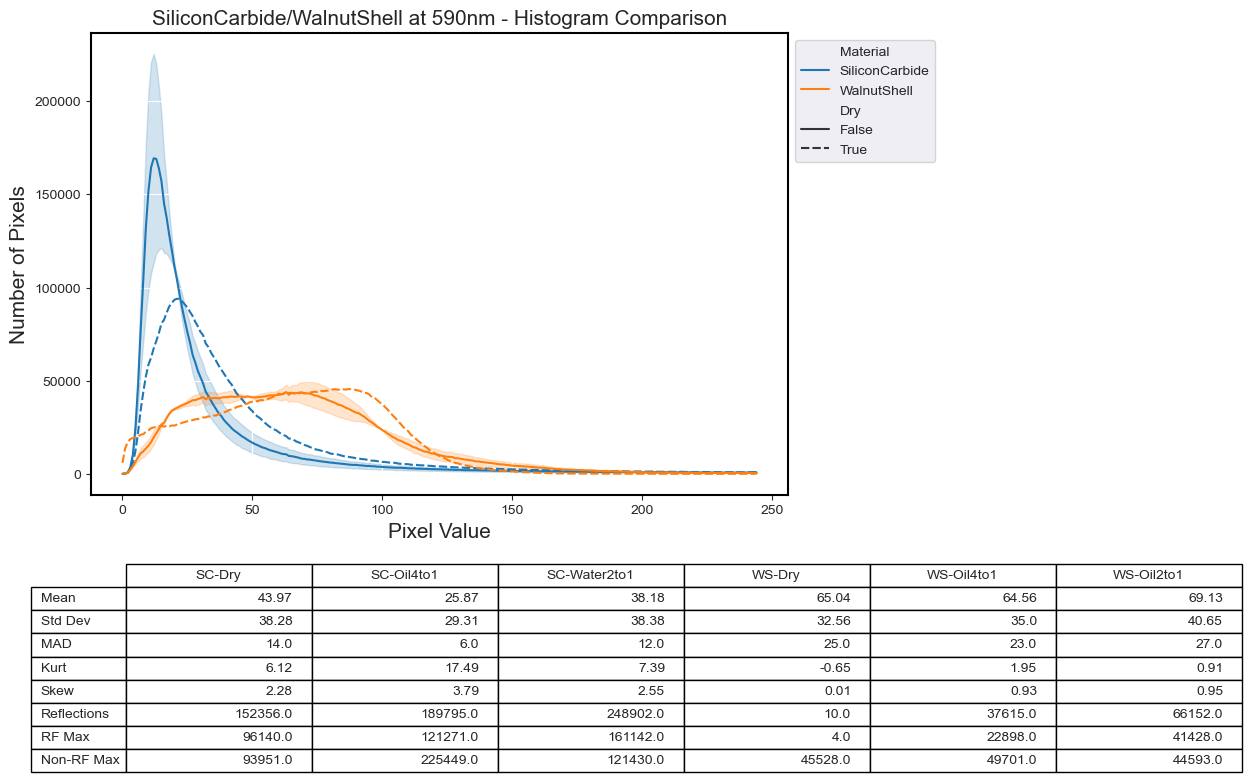

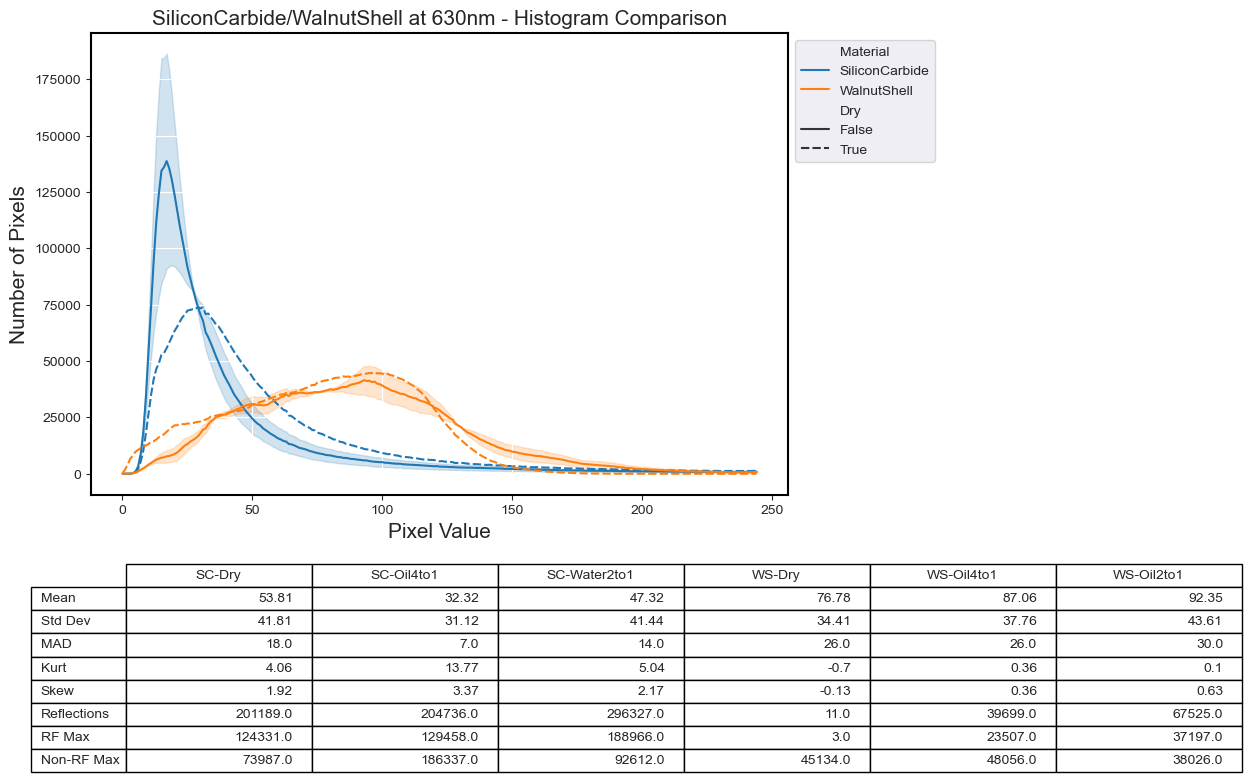

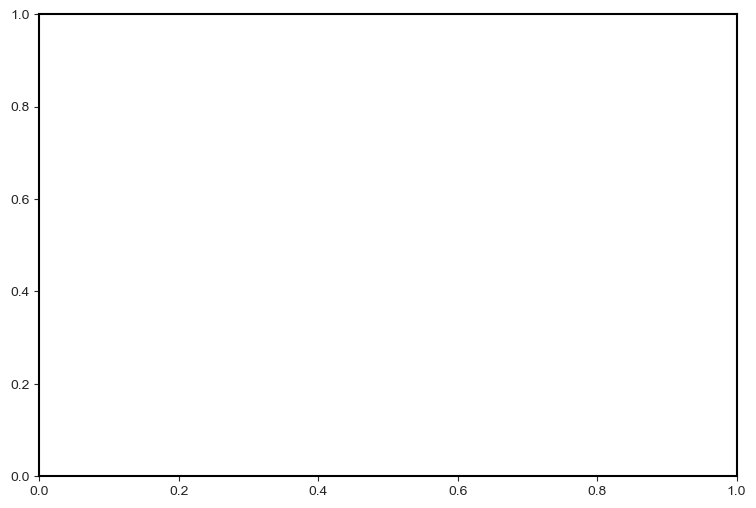

In [28]:
#Individual histograms with statistics
#----------------------------------------------------------------------------------------------------------------------------
# User input

#["Anthracite", "SiliconCarbide", "40umGlassBead", "750umGlassBead", "WalnutShell", "EpsomSalt", "ParaffinWax"]
materials = ["SiliconCarbide", "WalnutShell"]

#[455, 525, 590, 630, 770, 850, 870, 935]
wavelengths = ['455', '525', '590', '630']

#[Dry, Water, Oil, Glycerin]
conditions = ["Dry", "Water", "Oil", "Glycerin"]

#To cut off the reflections in the histogram and stat calculations in order to prevent interefence (True/False)
trimmed = True

#save image to specified folder (True/False)
save = False

#what property the graph color will represent ["Combination", "Material"] 
#Material is best for trying to see patterns, especially with more than two materials and all conditions.
#Combination is best for looking for what might be causing an outlier in the material error bound. Can get very messy with many materials and conditions.
differentiation = "Material"

#setting the location of the file structure
base = '/Users/fanjx1/Documents/SandImages'

#----------------------------------------------------------------------------------------------------------------------------
#Functions

#Finds which conditions being searched for are valud for a material. Prevents the program from looking for a combination that doesn't exist.
def conditionList(material, possibleConditions):
     searchPath = os.path.join(base,'Composites', '*' + material + '*')
     conditionsInMaterial = glob.glob(searchPath)
     condList = []
     for condition in conditionsInMaterial:
          baseName = os.path.basename(condition)
          for possible in possibleConditions:
               if possible in baseName: 
                    condList.append(possible)
     return np.unique(np.array(condList))  


#Opens and flattens the image array in preparation for the histogram
def ioOpen(imageFile):
    return np.ravel(io.imread(imageFile))


def createHistogram(images, materials, differentiation):
     #Generating the pixel counts per value for each image
     histogramData = pd.DataFrame({"Pixel Value" : list(range(245))})
     for key, value in images.items(): 
          values, counts = np.unique(value,return_counts= True)

          #Makes sure that missing values are filled in to enable attachment to a dataframe
          filledCounts = []
          for valueNumber in list(range(245)):
               if valueNumber in values:
                    countIndex = np.where(values == valueNumber)[0]
                    filledCounts.append(counts[*countIndex])
               else:
                    filledCounts.append(0)
          histogramData[key] = filledCounts

     #Converts the table into a form that can be plotted from and adds a dry tag that can used for visual differentiation on the plot
     histogramData = histogramData.melt(id_vars = ["Pixel Value"], value_vars = histogramData.columns[1:], var_name='Combination', value_name='Number of Pixels')
     histogramData["Dry"] = histogramData["Combination"].apply(lambda x: "Dry" in x)
     histogramData["Material"] = ''
     for material in materials:
          histogramData.loc[histogramData["Combination"].str.contains(material), "Material"] = material

     sns.set_style("darkgrid")
     sns.lineplot(histogramData, x = "Pixel Value", y = "Number of Pixels" , hue = differentiation, style = "Dry")
     sns.move_legend(ax, loc = "upper left", bbox_to_anchor=(1, 1))
     ax.set_title("/".join(materials) + " at " + wavelength + "nm - Histogram Comparison")
     ax.set_xlabel("Pixel Value")
     ax.set_ylabel("Number of Pixels")


#Generates a selected statsistics from an array of pixel values. 
def statList(imageArray, reflections, reflectMax):
    values, nonRFCounts = np.unique(imageArray[imageArray < 245],return_counts=True)
    return [round(np.mean(imageArray),2),
            round(np.std(imageArray),2),
            scipy.stats.median_abs_deviation(imageArray),
            round(scipy.stats.kurtosis(imageArray),2),
            round(scipy.stats.skew(imageArray),2),
            reflections,
            reflectMax,
            nonRFCounts.max()]


#Gets rid of all the highlights (> 245) from a pixel value array 
def highlightTrim(imageArray):
     imageArray = imageArray
     trimmedArray = imageArray[imageArray < 245]
     return trimmedArray


#----------------------------------------------------------------------------------------------------------------------------
#Main

fig, ax = plt.subplots(figsize = (9,6))
stats = {}

for wavelength in wavelengths: #wavelength is '.../Material-ConditionRatio/Wavelength-.tiff', etc
     images = {} #Dictonary that will hold all the combination names and their respective image arrays.

     #Gets an image and statistics calculation for every combination in preparation for the histogram and datatable beneath it.
     for material in materials:
          conditionsInMaterial = conditionList(material, conditions)
          for condition in conditionsInMaterial: #A combination is a material (walnut shell/glass beads/anthracite...) and condition (dry/water/oil...)
               searchPath = os.path.join(base,'Composites', '*' + material + '*' + condition + '*','*' + wavelength + '*')
               for combination in glob.glob(searchPath):
                    combName = os.path.basename(os.path.dirname(combination)) #'WalnutShell-MineralOil4to1'
                    combSplit = combName.partition('-') #['WalnutShell','-','MineralOil4to1']
                    shortenedCombName = "".join(char for char in combSplit[0] if (char.isupper() or char.isnumeric())) + "-" + combSplit[2]

                    imageArray = ioOpen(combination)

                    #Statistics to quantify reflections
                    reflections = imageArray[imageArray > 245]
                    if np.size(reflections) < 1:
                         reflectCount = 0
                         reflectMax = 0
                    else: 
                         reflectCount = np.size(reflections)
                         reflectMax = np.unique(imageArray[imageArray > 245],return_counts= True)[1].max()

                    #Removing reflections
                    if trimmed:
                         imageArray = highlightTrim(imageArray)
                    
                    stats[shortenedCombName] = statList(imageArray, reflectCount, reflectMax)
                    images[combName] = imageArray

     createHistogram(images, materials, differentiation)

     #Creates a table for stats underneath each graph
     statComparison = pd.DataFrame(stats, index = ['Mean', 'Std Dev', 'MAD', 'Kurt', 'Skew', 'Reflections', 'RF Max', 'Non-RF Max'])
     wavelengthStats = mpl.table.table(ax,
                     cellText= statComparison.values,
                     colLabels = statComparison.columns,
                     rowLabels = statComparison.index,
                     bbox = (0.05, -0.6 ,1.6 ,0.45))
     wavelengthStats.auto_set_font_size(False)
     wavelengthStats.set_fontsize(10)

     #If choosing to save, finds the path the plot should be put in.
     if save:
          #Plot file name
          if len(materials) > 1:
               plotName = "-".join(("".join(char for char in material if (char.isupper() or char.isnumeric()))) for material in materials) + "-" + wavelength[-5:]
          else:
               plotName = material + wavelength[:-5]

          if trimmed:
               plotName = material + wavelength[:-5] + 'CutHistogram.png'
          else:
               plotName = material + wavelength[:-5] + 'Histogram.png'
     
          #Plot file directory
          if len(materials) > 1:
               plotDir = os.path.join(base, 'ImageStatistics', "Mixed")
          else:
               plotDir = os.path.join(base, 'ImageStatistics', materials[0])
          
          if os.path.exists(fileName) == False:
               os.mkdir(fileName)
          fig.savefig(os.path.join(plotDir, plotName), bbox_inches= 'tight')
          display(os.path.join(plotDir, plotName))
                  
     display(fig)
     stats.clear()
     ax.clear()


'/Users/fanjx1/Documents/SandImages/ImageStatistics/ParaffinWax'

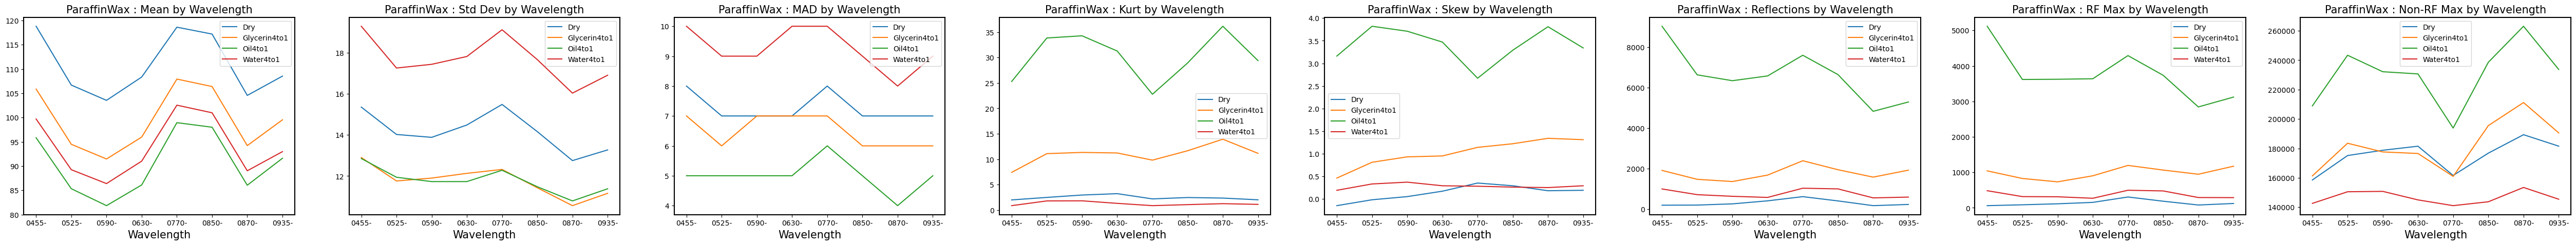

In [27]:
#Hist Stat v Wavelength for each condition, by Material

# User input
material = "ParaffinWax"

#to cut off the reflections
trimmed = True

#Path to SandImages folder
base = '/Users/fanjx1/Documents/SandImages'


def statList(imageArray, reflections, reflectMax):
    values, nrCounts = np.unique(imageArray[imageArray < 245],return_counts=True)
    return [round(np.mean(imageArray),2),
            round(np.std(imageArray),2),
            scipy.stats.median_abs_deviation(imageArray),
            round(scipy.stats.kurtosis(imageArray),2),
            round(scipy.stats.skew(imageArray),2),
            reflections,
            reflectMax,
            nrCounts.max()]


def highlightTrim(imageArray):
     imageArray = imageArray
     trimmedArray = imageArray[imageArray < 245]
     return trimmedArray


def ioOpen(imageFile):
    return np.ravel(io.imread(imageFile))


def conditionList(search):
     conds = []
     addresses = glob.glob(search)
     for address in addresses:
          conds.append(os.path.dirname(address))
     return [*np.unique(conds)]


searchPath = os.path.join(base, 'Composites', '*' + material + '*', '*')
conditions = conditionList(searchPath)
stats = {}

fig, axs = plt.subplots(1,8, figsize = (64,5))


for condition in conditions:
     wavelengthsInCondition = glob.glob(os.path.join(condition, '*'))
     wavelengthsInCondition.sort()
     # display(wavelengthsInCondition)
     
     #Get the statistics for each wavelength and store them in a dictionary
     for wavelength in wavelengthsInCondition: #wavelength is '.../Material-ConditionRatio/Wavelength-.tiff', etc
          combName = os.path.basename(os.path.dirname(wavelength)) #'WalnutShell-MineralOil4to1'
          combSplit = combName.partition('-') #['WalnutShell','-','MineralOil4to1']
          wavelengthName = os.path.basename(wavelength)[:-5]
          imageArray = ioOpen(wavelength)

          #Reflection involved statistics 
          reflections = imageArray[imageArray > 245]
          if np.size(reflections) < 1:
               reflectCount = 0
               reflectMax = 0
          else: 
               reflectCount = np.size(reflections)
               reflectMax = np.unique(imageArray[imageArray > 245],return_counts= True)[1].max()

          #Removing reflections
          if trimmed:
               imageArray = highlightTrim(imageArray)
          
          stats[wavelengthName] = statList(imageArray, reflectCount, reflectMax) #{'Dry' : [100, 20, 2, 17, 2, 100], 'Water' : [60, 12, 4, 39, 1, 230]...}

     #Create dataframe that will be graphed from and resets the dictonary for the next statistic
     combName = os.path.basename(condition) #comb (combination) is a material (walnut shell/glass beads/anthracite...) and condition (dry/water/oil...)
     combSplit = combName.partition('-') #['WalnutShell','-','MineralOil4to1']
     statData = pd.DataFrame(stats, index = ['Mean', 'Std Dev', 'MAD', 'Kurt', 'Skew', 'Reflections', 'RF Max', 'Non-RF Max'])
     # display(statData)
     stats.clear()

     #Plotting the respective statistics by wavelength profile on each axis for the given condition
     statCount = 0
     for stat in statData.index:
          axs[statCount].set_title(material + ' : ' + stat + ' by Wavelength') #'WalnutShell : Mean by Wavelength'
          axs[statCount].plot(statData.loc[stat], label = combSplit[2])
          axs[statCount].legend(loc='best')
          axs[statCount].xaxis.set_label_text('Wavelength')
          statCount += 1 

pictureName = material + 'StatisticsProfiles.png'
if os.path.exists(os.path.join(base, 'ImageStatistics', combSplit[0])) == False:
     os.mkdir(os.path.join(base, 'ImageStatistics', combSplit[0]))
display(os.path.join(base, 'ImageStatistics', combSplit[0]))
fig.savefig(os.path.join(base, 'ImageStatistics', combSplit[0], pictureName), bbox_inches= 'tight')

In [ ]:
#Box Plots

# User input
#455, 525, 590, 630, 770, 850, 870, 935
wavelengths = ['455', '525', '590', '630']

#must add in all conditions
conditions = ['Dry', 'Water', 'Oil', 'Glycerin']

#must add in desired samples
materials = ['Anthracite', 'SiliconCarbide']

#finding the wavelengths present in the folder
base = '/Users/fanjx1/Documents/SandImages'


def ioOpen(image):
    return io.imread(image)


#Finds all the conditions that are present in the choosen wavelength
#then assign conditions as keys in a dictionary and sorts images to them.
def condDict(conds, images):
    existing = []
    for cond in conds:
        if any(cond in image for image in images):
            existing.append(cond)
    # display(existing)
    condDict = {cond : [] for cond in existing}
    for image in images:
        [condDict[cond].append(image) for cond in conds if cond in image]
    return condDict


def statList(imageArray):
    return [round(np.mean(imageArray, axis=(0, 1)),2),
            round(np.std(imageArray, axis=(0, 1)),2),
            scipy.stats.median_abs_deviation(imageArray, axis = (0,1)),
            round(scipy.stats.kurtosis(imageArray, axis = (0,1)),2),
            round(scipy.stats.skew(imageArray, axis = (0,1)),2)]


#Gets statistics from a list of images and groups statistics by type (mean/standard deviation/skew...) in a list
def statsZip(imageList):
    stats = []
    for image in imageList:
        stats.append(statList(ioOpen(image)))
    conditionStats = list(zip(*stats))
    return conditionStats


imageList = []
for material in materials:
    for wavelength in wavelengths:
        searchPath = os.path.join(base, 'Composites', '*' + material + '*', '*' + wavelength + '*')
        imageList.extend(glob.glob(searchPath))
imagesSorted = condDict(conditions, imageList)
fig, axs = plt.subplots(1, 5, figsize = (40,5))

#Create dataframe to be plotted from
statsDict = {}
for cond in imagesSorted.keys():
    statsDict[cond] = statsZip(imagesSorted[cond])
statIndex = ['Mean', 'Std Dev', 'MAD', 'Kurt', 'Skew']
materialStats = pd.DataFrame(statsDict, index = statIndex, columns = statsDict.keys())

#Plots a box plot of each condition's statistics on the respective statistic graph 
materialsStatList = []
axsCount = 0
for stat in materialStats.index:
    for condition in materialStats.columns:
        materialsStatList.append(np.array(materialStats.loc[stat, condition]))
    axs[axsCount].boxplot(materialsStatList, labels = materialStats.columns)
    axs[axsCount].set_title(stat)
    materialsStatList.clear()
    axsCount += 1
plt.suptitle('-'.join(materials) + ' || ' + '-'.join(wavelengths), x = 0.5, y = 1.05, fontsize = 20)

pictureName = wavelength + 'BoxPlots.png'
fig.savefig(os.path.join(base, 'ImageStatistics', 'ByWavelength', pictureName), bbox_inches= 'tight')

## Edge Detection

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0455-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0455-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0455-.tiff']

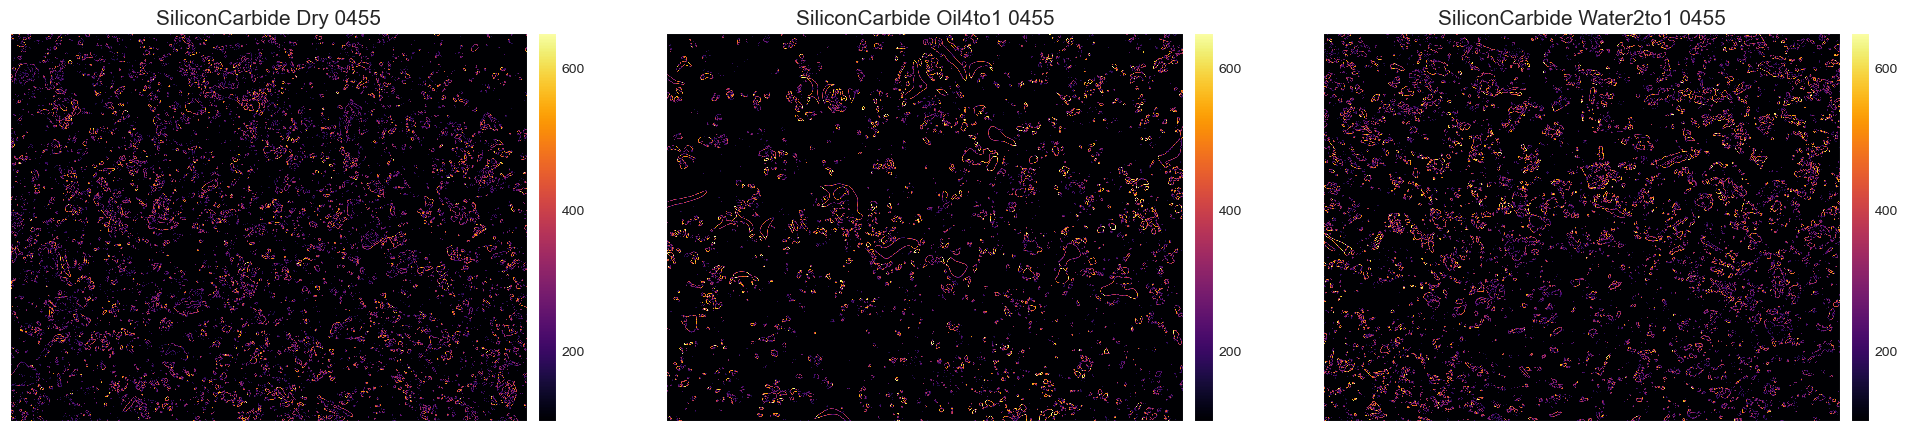

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0455EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0525-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0525-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0525-.tiff']

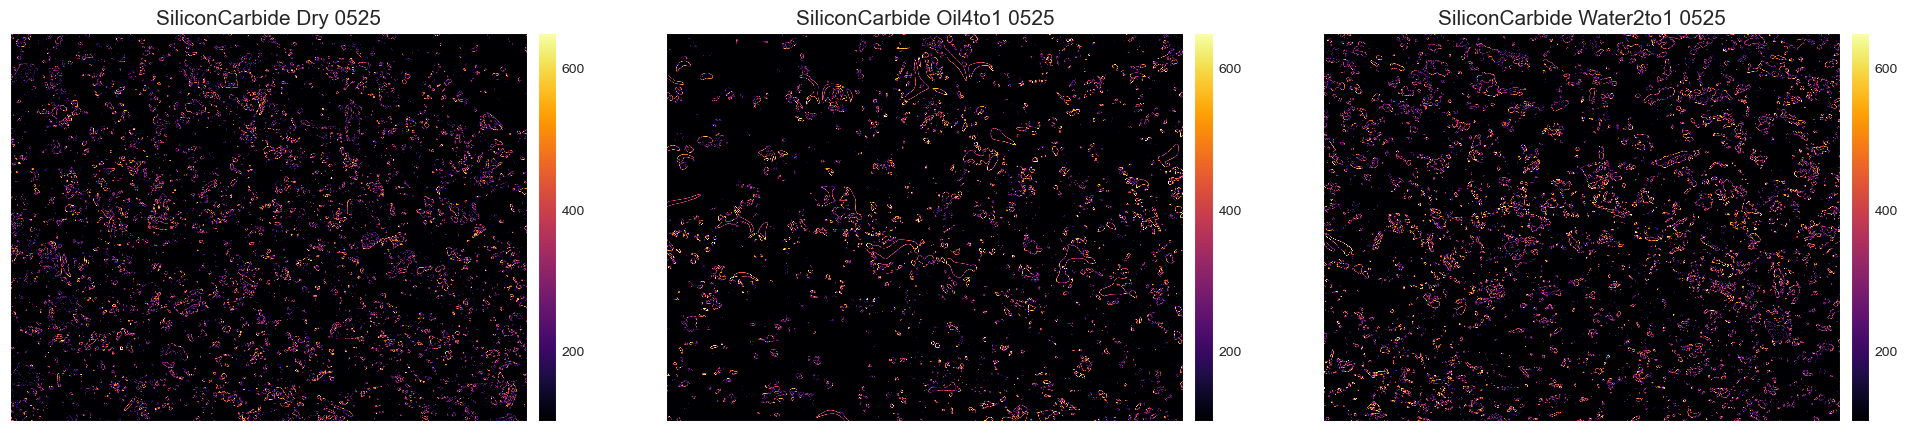

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0525EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0590-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0590-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0590-.tiff']

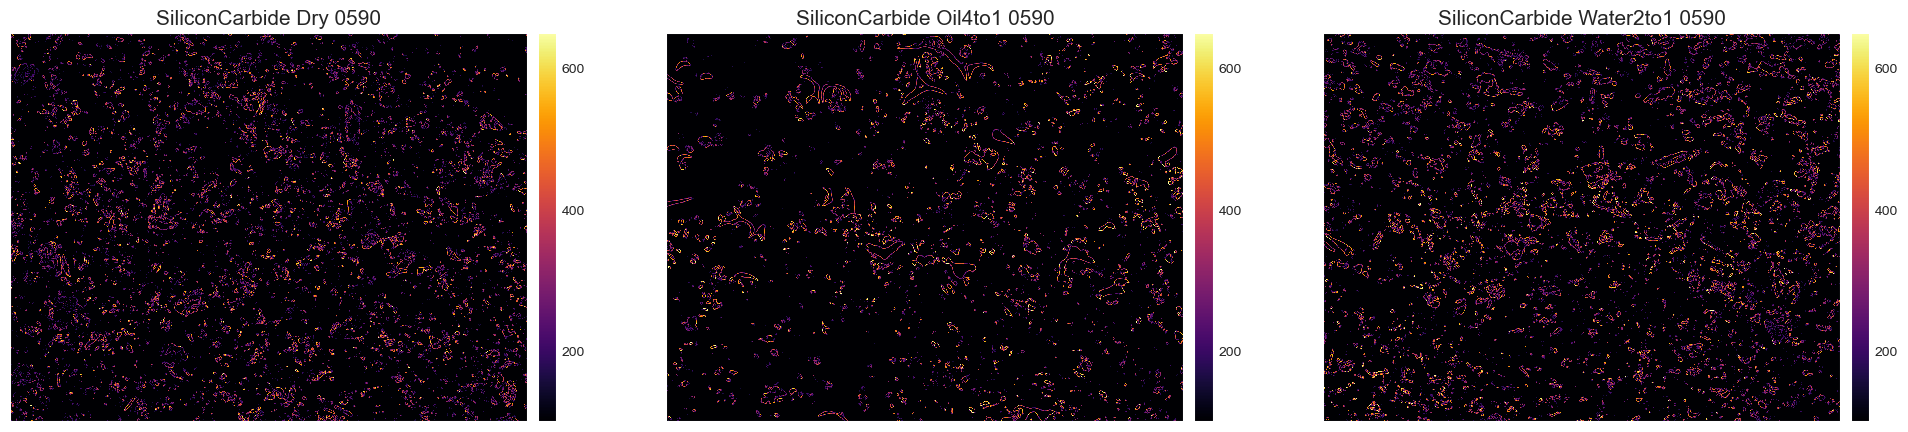

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0590EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0630-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0630-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0630-.tiff']

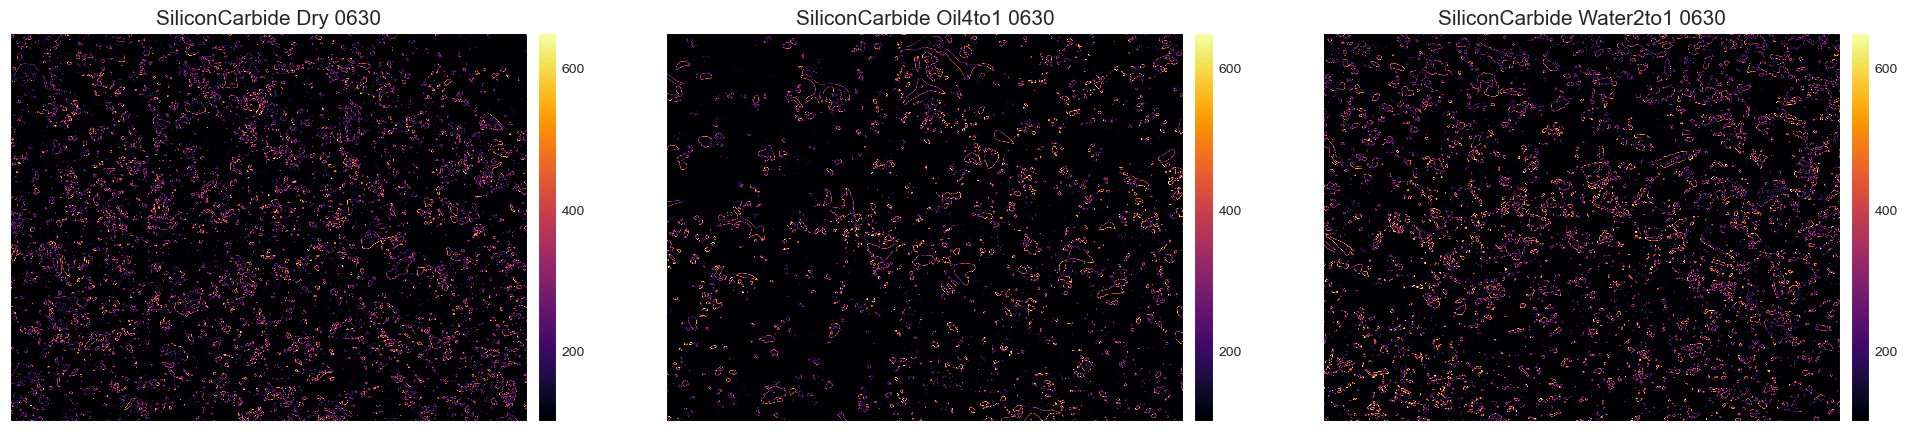

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0630EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0770-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0770-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0770-.tiff']

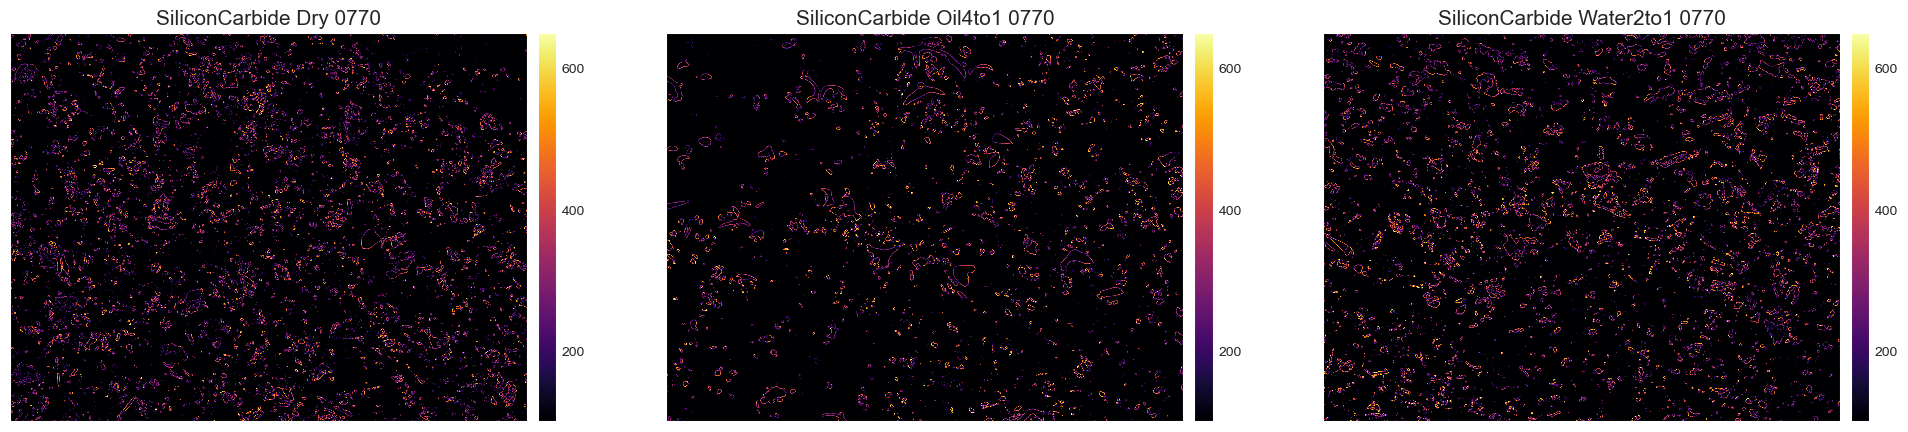

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0770EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0850-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0850-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0850-.tiff']

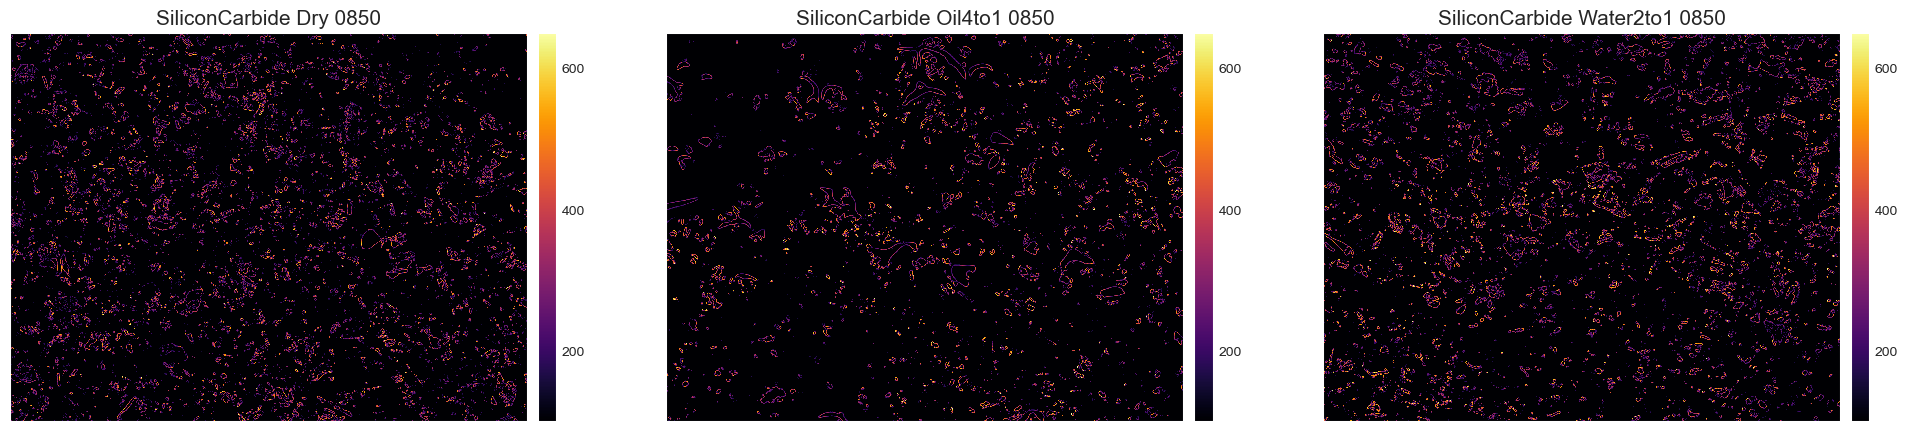

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0850EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0870-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0870-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0870-.tiff']

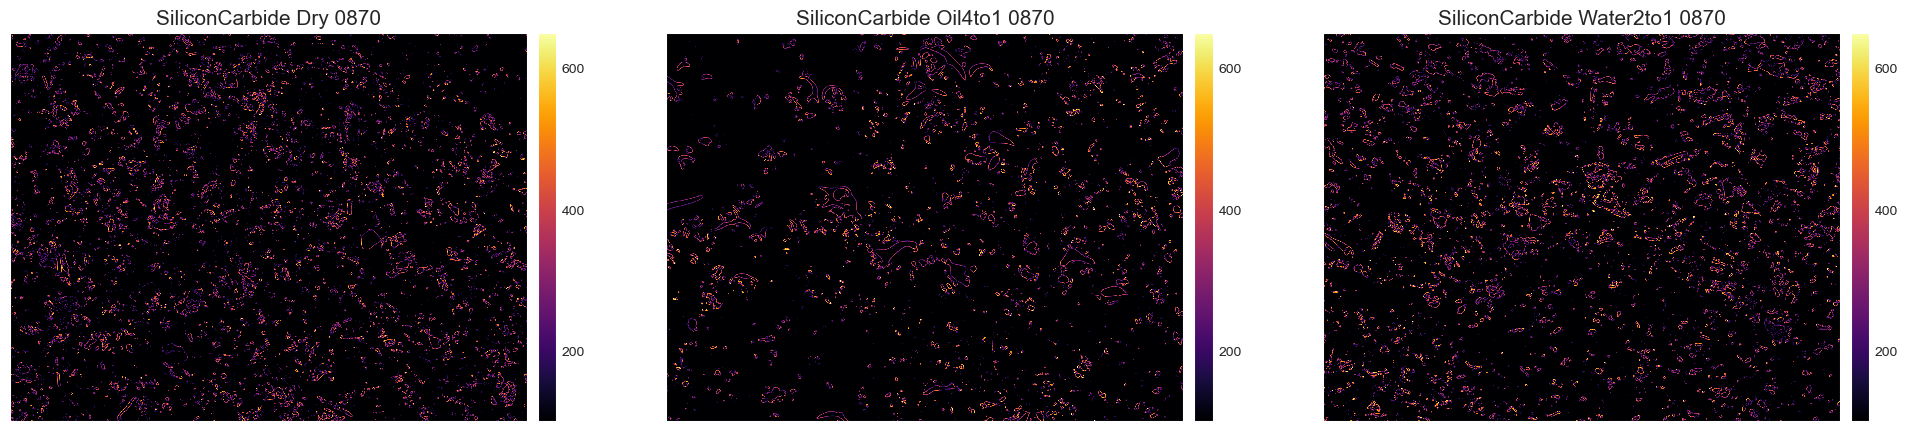

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0870EdgeThresh.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0935-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0935-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0935-.tiff']

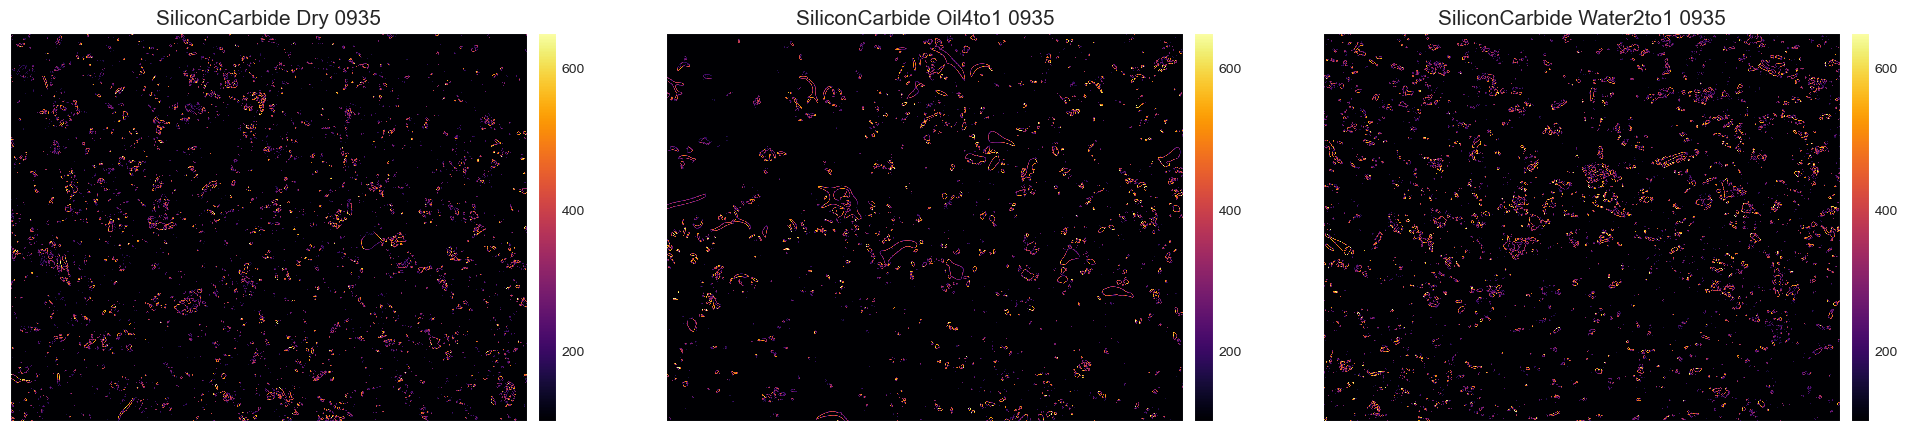

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0935EdgeThresh.png'

In [62]:
#Thresholded images

#Returns an array with the intensity of the edges 
def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    dx = cv2.Sobel(im, cv2.CV_32F, 1, 0)
    dy = cv2.Sobel(im, cv2.CV_32F, 0, 1)
    dxabs = np.absolute(dx)
    dyabs = np.absolute(dy)
    dxy = cv2.magnitude(dxabs, dyabs)
    return dxy


def gaussBlur(im):
    blurred = cv2.GaussianBlur(im, ksize = (3,3), sigmaX = 0, sigmaY = 0)
    return blurred


def edgeThreshold(edges, threshold):
    edges[edges < threshold] = 0
    return edges


def wavelengthList(search):
    wavelengths = []
    addresses = glob.glob(search)
    for address in addresses:
        wavelengths.append(os.path.basename(address).partition('-')[0])
    return [*np.unique(wavelengths)]

def conditionList(search):
    conditions = []
    addresses = glob.glob(search)
    for address in addresses:
        conditions.append(os.path.basename(address).partition('-')[2])
    return sorted(conditions)



material = "SiliconCarbide"

base = "/Users/fanjx1/Documents/SandImages/"

wavelengths = wavelengthList(os.path.join(base, 'Composites', '*' + material + '*', '*0*'))
conditions = conditionList(os.path.join(base, 'Composites', '*' + material + '*'))
material = os.path.basename(glob.glob(os.path.join(base, 'Composites', '*' + material + '*'))[0]).partition('-')[0]

fileName = os.path.join(base, 'ImageStatistics', material)
if os.path.exists(fileName) == False:
        os.mkdir(fileName)

condCount = len(conditions)
threshold = 150
for wavelength in wavelengths:
    axCount = 0
    fig1, ax = plt.subplots(1, condCount, figsize = (condCount * 8, 12))
    for condition in conditions:
        path = glob.glob(os.path.join(base, 'Composites', '*' + material + '*' + condition + '*', '*' + wavelength + '*'))
        display(path)
        thresholded = edgeThreshold(getGradientMagnitude(gaussBlur(cv2.imread(*path, 0))), threshold).astype(int)
        # display(np.unique(thresholded))
        isns.imgplot(thresholded, ax[axCount], cmap='inferno', vmin = 100 , vmax = 650, origin = 'upper')
        ax[axCount].set_title(material + ' ' + condition + ' ' + wavelength)
        axCount += 1
    plt.show()

    plotName = material + wavelength + 'EdgeThresh.png'
    fig1.savefig(os.path.join(fileName, plotName), bbox_inches= 'tight')
    display("Saved to : {}".format(os.path.join(fileName, plotName)))
    fig1.clear()

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0455-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0455-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0455-.tiff']

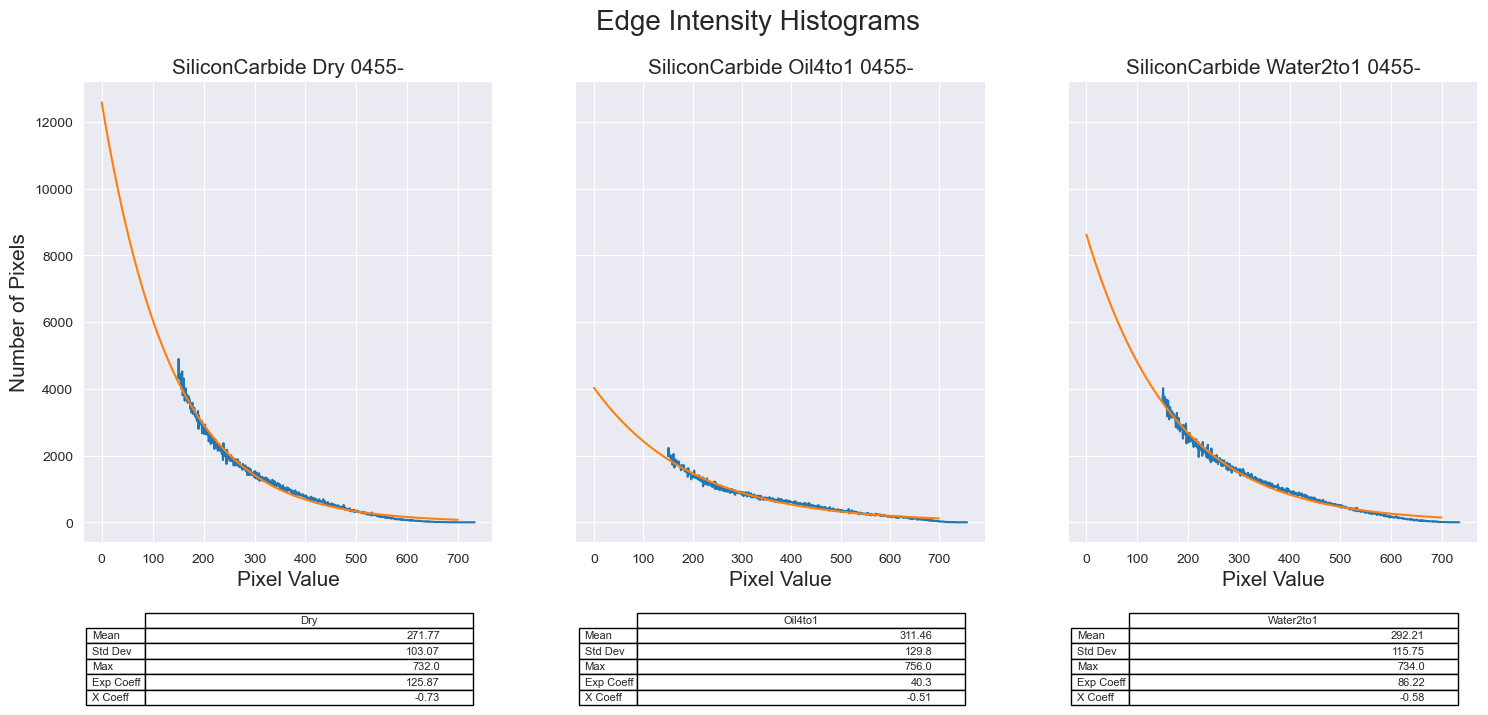

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0455-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0525-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0525-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0525-.tiff']

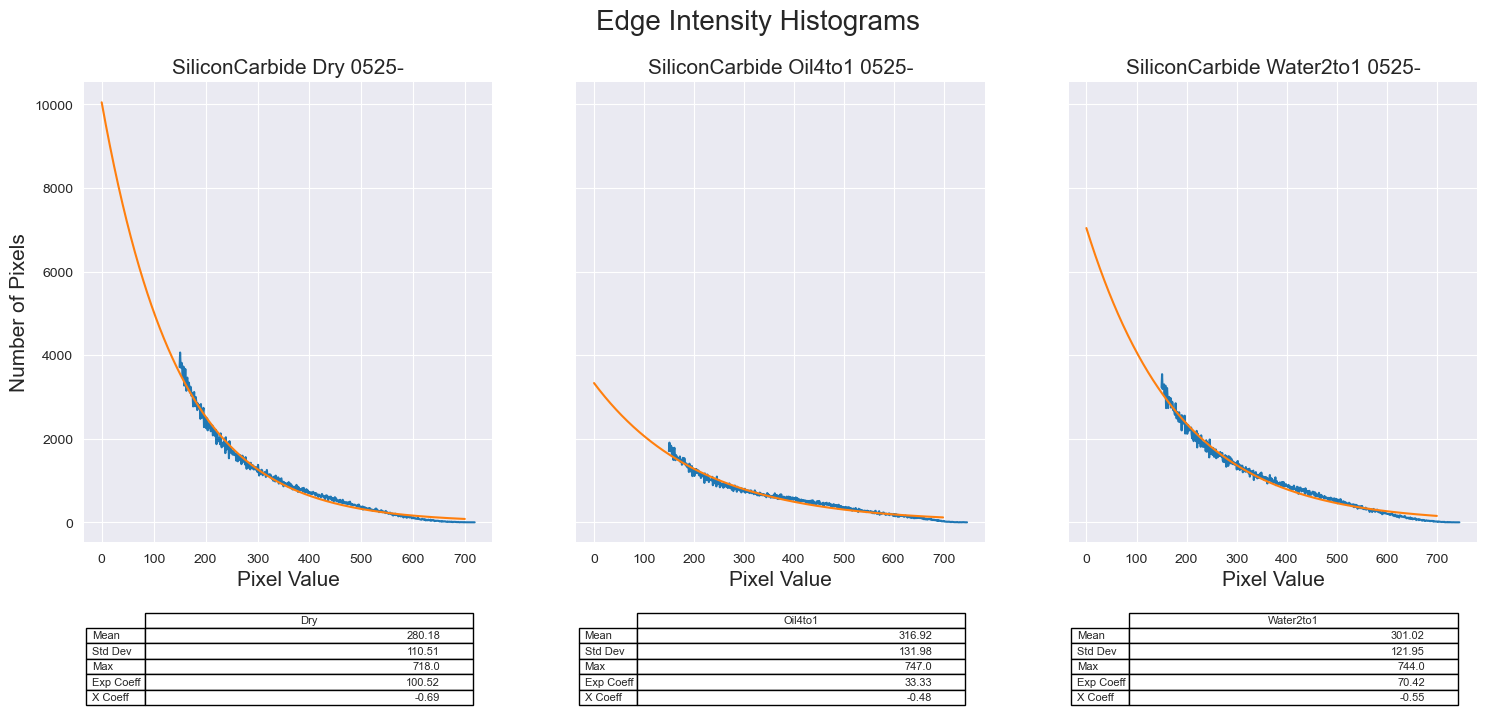

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0525-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0590-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0590-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0590-.tiff']

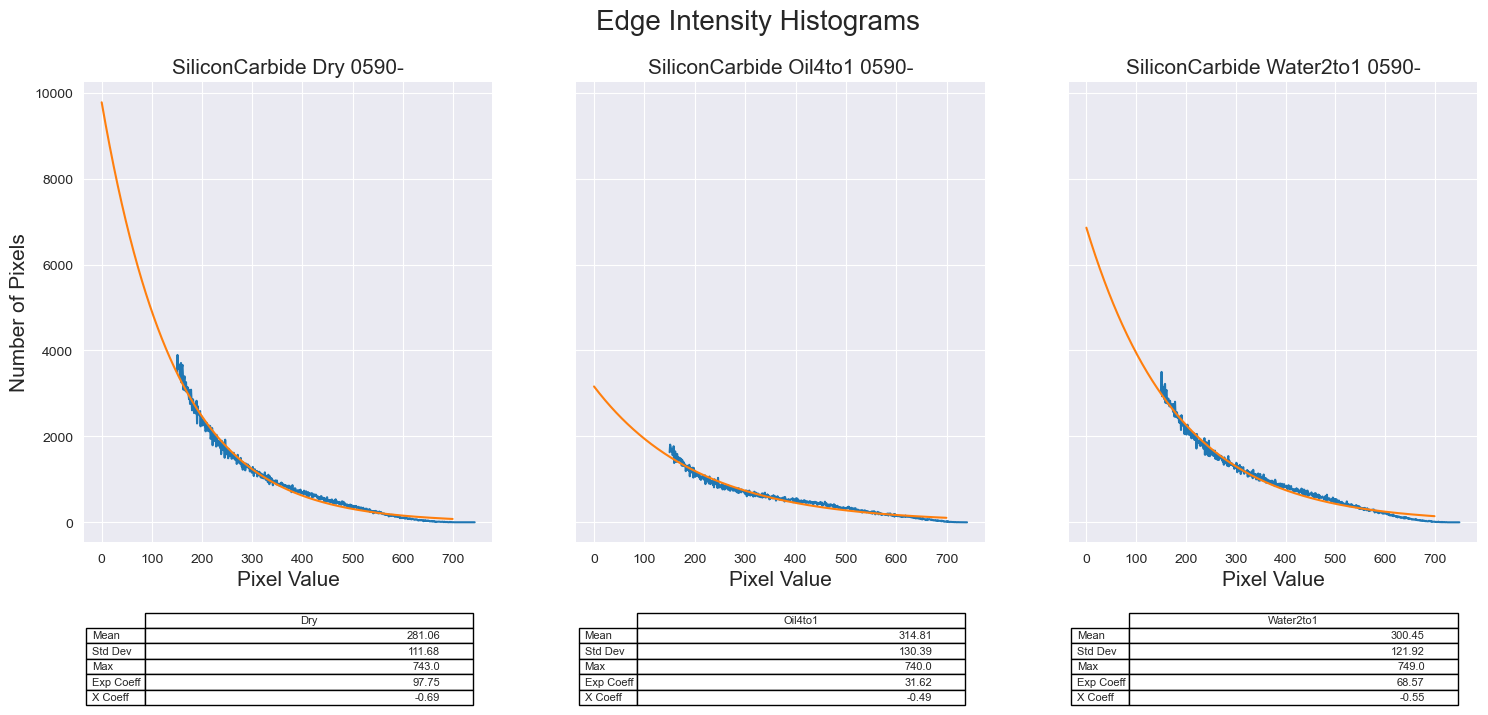

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0590-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0630-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0630-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0630-.tiff']

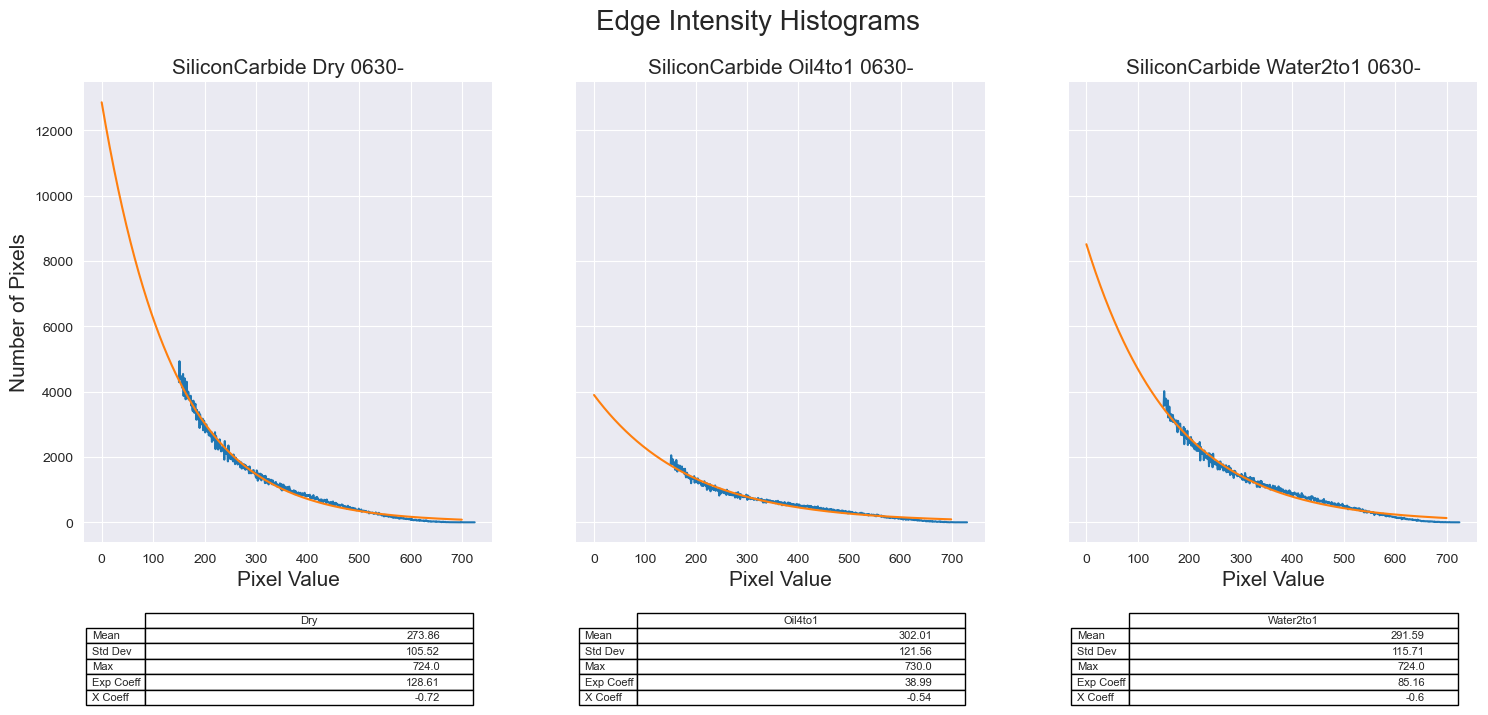

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0630-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0770-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0770-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0770-.tiff']

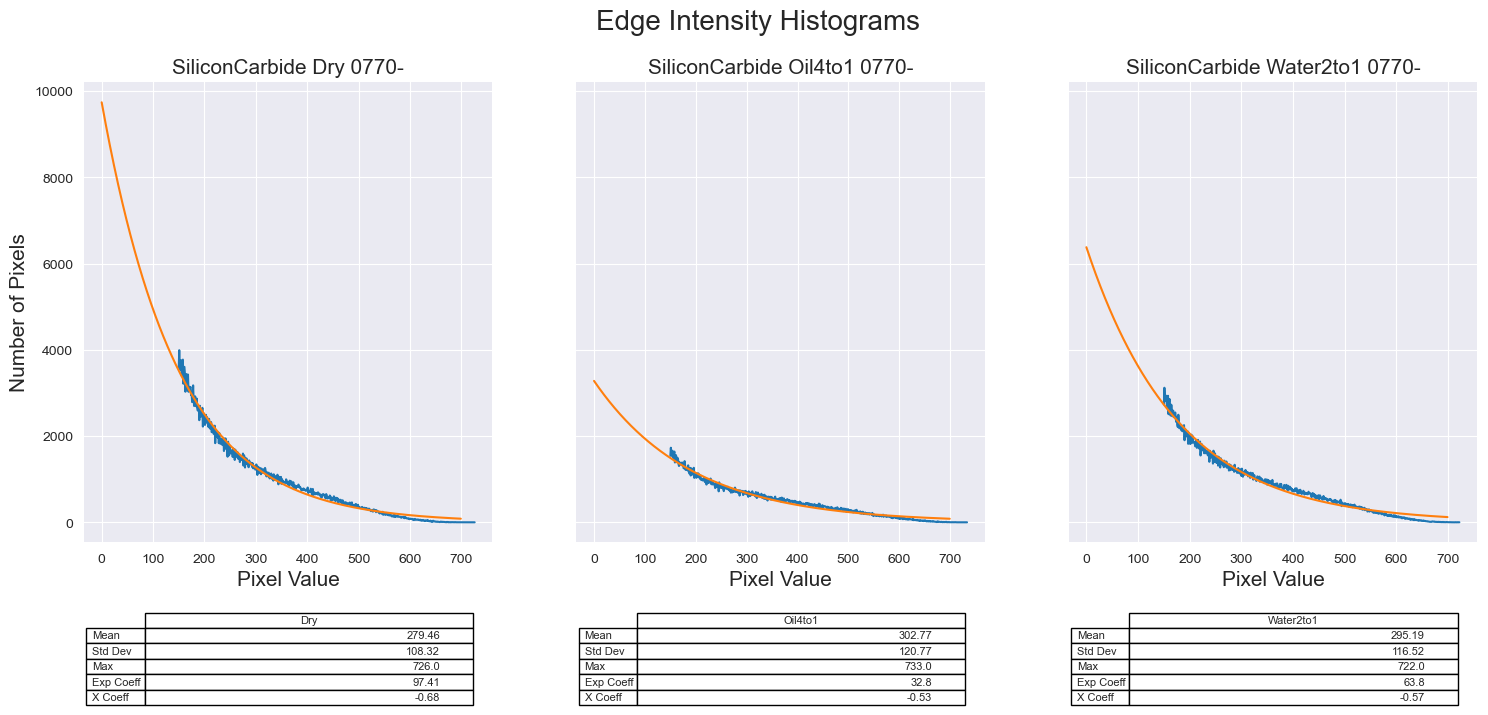

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0770-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0850-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0850-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0850-.tiff']

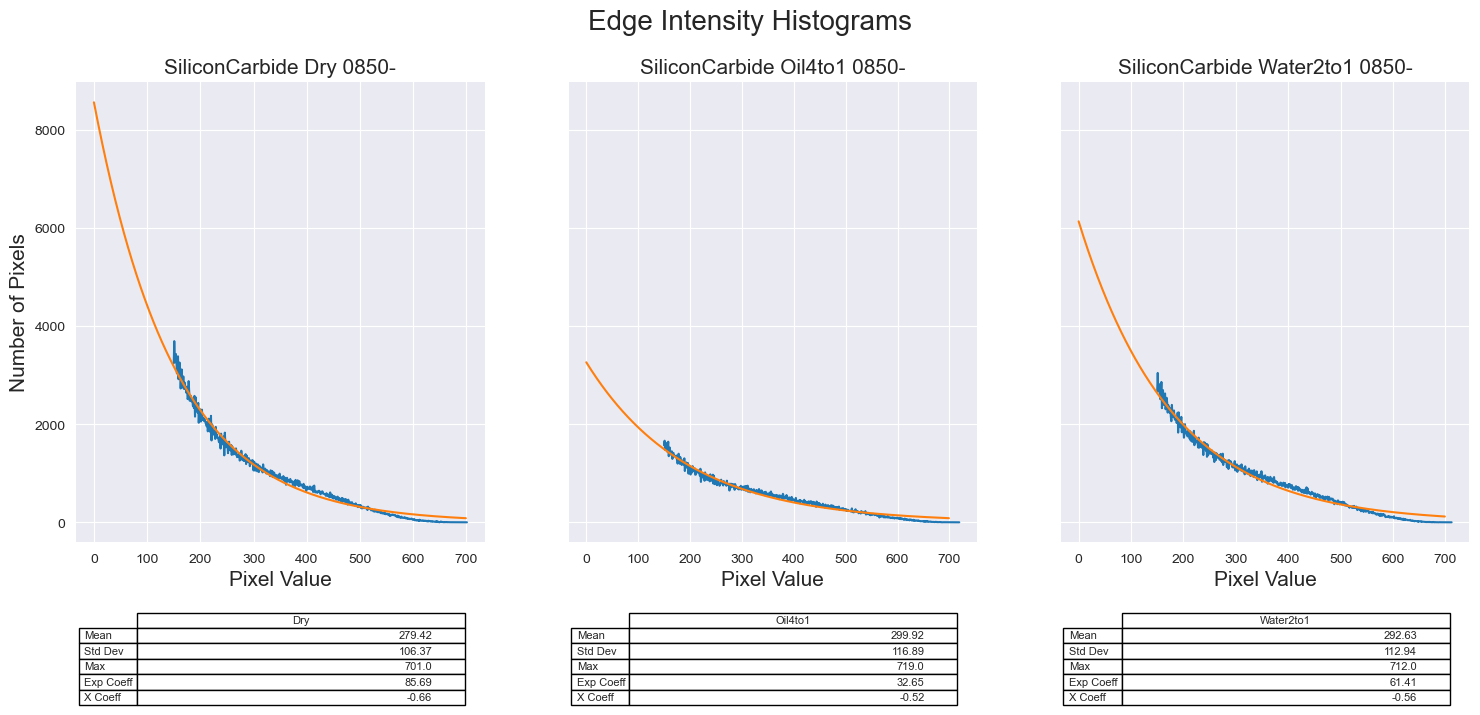

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0850-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0870-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0870-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0870-.tiff']

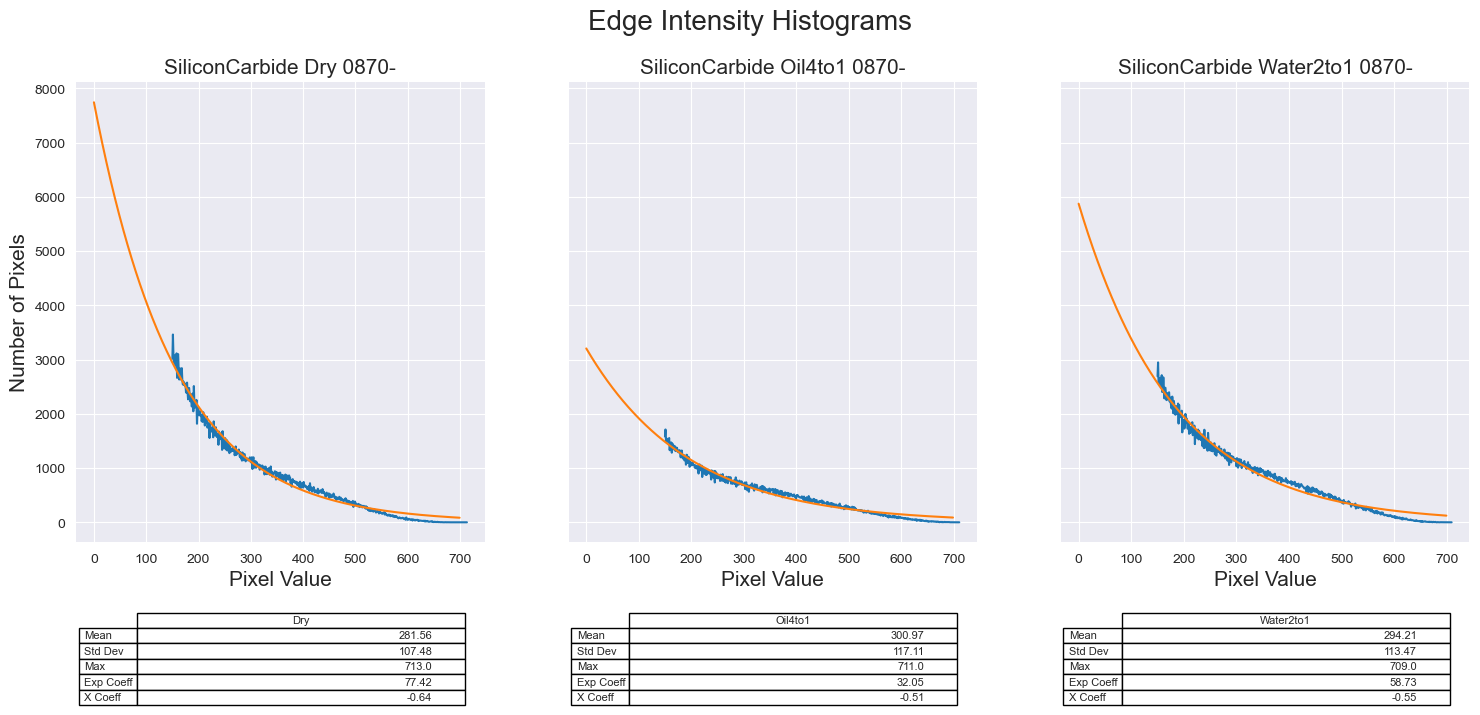

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0870-EdgeThreshHist.png'

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0935-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Oil4to1/0935-.tiff']

['/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Water2to1/0935-.tiff']

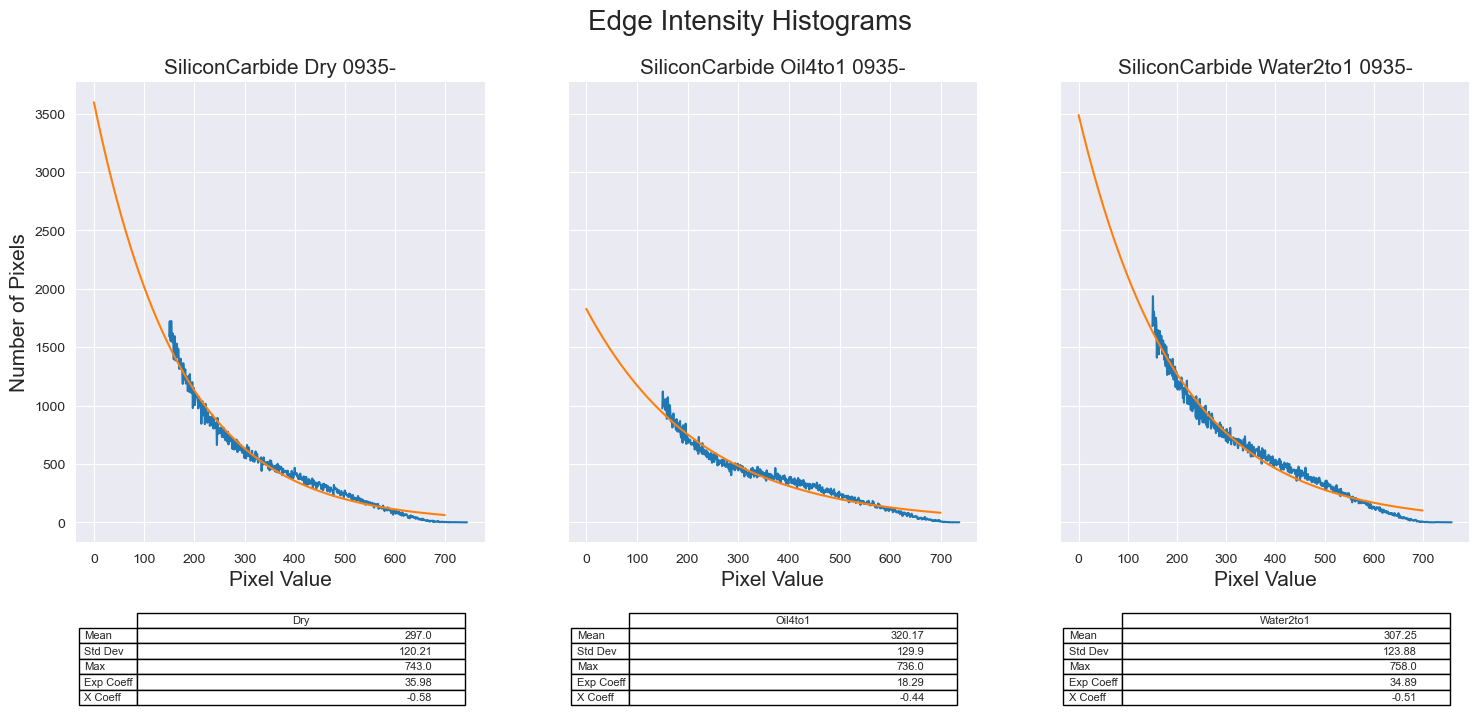

'Saved to : /Users/fanjx1/Documents/SandImages/ImageStatistics/SiliconCarbide/SiliconCarbide0935-EdgeThreshHist.png'

In [68]:
#Thresholded histogram

#Returns an array with the intensity of the edges 
def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    dx = cv2.Sobel(im, cv2.CV_32F, 1, 0)
    dy = cv2.Sobel(im, cv2.CV_32F, 0, 1)
    dxabs = np.absolute(dx)
    dyabs = np.absolute(dy)
    dxy = cv2.magnitude(dxabs, dyabs)
    return dxy


def gaussBlur(im):
    blurred = cv2.GaussianBlur(im, (3,3), 0)
    return blurred


#Returns an array that has all the values below the threshold eliminated
def edgeThreshold(edges, threshold):
    edges[edges < threshold] = 0
    return edges


#Returns a list of statistics to be passed into a table
def statList(imageArray, popt):
    return [round(np.mean(imageArray), 2),
            round(np.std(imageArray), 2),
            max(imageArray),
            round(popt[0], 2),
            round(popt[1], 2),]


#Returns all the wavelengths that a material has been imaged under
def wavelengthList(search):
    wavelengths = []
    addresses = glob.glob(search)
    for address in addresses:
        wavelengths.append(os.path.basename(address))
    return [*np.unique(wavelengths)]


#Returns all the conditions (Dry, Water2to1, Water4to1, Oil4to1, etc...) that a material has been imaged under
def conditionList(search):
    conditions = []
    addresses = glob.glob(search)
    for address in addresses:
        conditions.append(os.path.basename(address).partition('-')[2])
    return sorted(conditions)


#Function used for regession calculations
def func(x, a, b):
    return a * np.exp(b * x)


material = "SiliconCarbide"
base = "/Users/fanjx1/Documents/SandImages/"

conditions = conditionList(os.path.join(base, 'Composites', '*' + material + '*'))
wavelengths = wavelengthList(os.path.join(base, 'Composites', '*' + material + '*', '*0*'))
material = os.path.basename(glob.glob(os.path.join(base, 'Composites', '*' + material + '*'))[0]).partition('-')[0]

#Checking image statistics file exists and creates is not
fileName = os.path.join(base, 'ImageStatistics', material)
if os.path.exists(fileName) == False:
        os.mkdir(fileName)

condCount = len(conditions)
threshold = 150

#Cycles through each condition within a wavelength, finds edges and visualizes intensity on a plot
for wavelength in wavelengths:
    axCount = 0
    fig1, ax = plt.subplots(1, len(conditions), figsize = (len(conditions) * 6, 6), sharey= True)
    plt.suptitle("Edge Intensity Histograms", x = 0.5, y = 1.00, fontsize = 20)
    ax[0].set_ylabel("Number of Pixels")
    
    for condition in conditions:
        path = glob.glob(os.path.join(base, 'Composites', '*' + material + '*' + condition + '*', '*' + wavelength + '*'))
        display(path)
        thresholded  = edgeThreshold(getGradientMagnitude(gaussBlur(cv2.imread(*path, 0))), threshold).astype(int)
        ax[axCount].plot(np.unique(thresholded, return_counts = True)[0][1:], np.unique(thresholded, return_counts = True)[1][1:])
        ax[axCount].set_title(material + ' ' + condition + ' ' + wavelength[:-5])
        ax[axCount].set_xlabel("Pixel Value")        

        #Makes sure that images without any highlights above the threshold don't break the program. The histogram of these images are blank.
        if len(np.unique(thresholded)) > 1:
            popt, conf = scipy.optimize.curve_fit(func, np.unique(thresholded, return_counts = True)[0][1:]/100, np.unique(thresholded, return_counts = True)[1][1:]/100)
            ax[axCount].plot(np.arange(0, 7, 0.01) * 100, func(np.arange(0, 7, 0.01), popt[0], popt[1]) * 100)
            threshValues = thresholded[thresholded > threshold]
        else:
            popt = [0,0]
            threshValues = thresholded.flatten()

        #Making a table to display histogram statistics and regression parameters
        stats = statList(threshValues, popt) #{'Dry' : [100, 20, 2, 17, 2], 'Water' : [60, 12, 4, 39, 1]...}
        statComparison = pd.DataFrame(stats, columns = [condition], index = ['Mean', 'Std Dev', 'Max', 'Exp Coeff', 'X Coeff']) #Rows are stat names, columns are conditions
        wavelengthStats = mpl.table.table(ax[axCount],
                    cellText= statComparison.values,
                    colLabels = statComparison.columns,
                    rowLabels = statComparison.index,
                    bbox = (0.15,-0.35,0.8,0.2))
        wavelengthStats.auto_set_font_size(False)
        wavelengthStats.set_fontsize(8)
        stats.clear()
        axCount += 1
    plt.show()

    #Saving files 
    plotName = material + wavelength.partition('.')[0] + 'EdgeThreshHist.png'
    fig1.savefig(os.path.join(fileName, plotName), bbox_inches= 'tight')
    display("Saved to : {}".format(os.path.join(fileName, plotName)))
    fig1.clear()

In [ ]:
# Edge Profiles
material = "750umGlassBead"

#Path to SandImages folder
base = '/Users/fanjx1/Documents/SandImages'


#Returns an array with the intensity of the edges 
def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    dx = cv2.Sobel(im, cv2.CV_32F, 1, 0)
    dy = cv2.Sobel(im, cv2.CV_32F, 0, 1)
    dxabs = np.absolute(dx)
    dyabs = np.absolute(dy)
    dxy = cv2.magnitude(dxabs, dyabs)
    return dxy


def gaussBlur(im):
    blurred = cv2.GaussianBlur(im, (3,3), 0)
    return blurred


#Returns an array that has all the values below the threshold eliminated
def edgeThreshold(edges, threshold):
    edges[edges < threshold] = 0
    return edges


#Returns a list of statistics to be passed into a table
def statList(imageArray, popt):
    return [round(np.mean(imageArray), 2),
            round(np.std(imageArray), 2),
            max(imageArray),
            round(popt[0], 2),
            round(popt[1], 2),]


#Returns all the wavelengths that a material has been imaged under
def wavelengthList(search):
    wavelengths = []
    addresses = glob.glob(search)
    for address in addresses:
        wavelengths.append(os.path.basename(address))
    return [*np.unique(wavelengths)]


#Returns all the conditions (Dry, Water2to1, Water4to1, Oil4to1, etc...) that a material has been imaged under
def conditionList(search):
    conditions = []
    addresses = glob.glob(search)
    for address in addresses:
        conditions.append(address)
    return sorted(conditions)


#Function used for regession calculations
def func(x, a, b):
    return a * np.exp(b * x)


conditions = conditionList(os.path.join(base, 'Composites', '*' + material + '*'))
wavelengths = wavelengthList(os.path.join(base, 'Composites', '*' + material + '*', '*0*'))
material = os.path.basename(glob.glob(os.path.join(base, 'Composites', '*' + material + '*'))[0]).partition('-')[0]
filePath = os.path.join(base, 'ImageStatistics', material)
if os.path.exists(filePath) == False:
    os.mkdir(filePath)

fig, axs = plt.subplots(1,5, figsize = (40,5))
condCount = len(conditions)
threshold = 150
stats = {}


for condition in conditions:
    wavelengthsInCondition = glob.glob(os.path.join(condition, '*'))
    wavelengthsInCondition.sort()
    # display(wavelengthsInCondition)
     
    #Get the statistics for each wavelength and store them in a dictionary
    for wavelength in wavelengthsInCondition: #wavelength is '.../Material-ConditionRatio/Wavelength-.tiff', etc
        combName = os.path.basename(os.path.dirname(wavelength)) #'WalnutShell-MineralOil4to1'
        combSplit = combName.partition('-') #['WalnutShell','-','MineralOil4to1']
        wavelengthName = os.path.basename(wavelength)[:-5]
        thresholded  = edgeThreshold(getGradientMagnitude(gaussBlur(cv2.imread(wavelength, 0))), threshold).astype(int)

        #Ensure images without highlights >threshold don't break program. These image histograms are blank.
        if len(np.unique(thresholded)) > 1:
            popt, conf = scipy.optimize.curve_fit(func, np.unique(thresholded, return_counts = True)[0][1:]/100, np.unique(thresholded, return_counts = True)[1][1:]/100)
            threshValues = thresholded[thresholded > threshold]
        else:
            popt = [0,0]
            threshValues = thresholded.flatten()
        stats[wavelengthName] = statList(threshValues, popt) #{'Dry' : [100, 20, 2, 17, 2], 'Water' : [60, 12, 4, 39, 1]...}

    #Create dataframe that will be graphed from and resets the dictonary for the next statistic
    statData = pd.DataFrame(stats, index = ['Mean', 'Std Dev', 'Max', 'Exp Coeff', 'X Coeff']) #Rows are stat names, columns are conditions
    stats.clear()

    #Plotting the respective statistics by wavelength profile on each axis for the given condition
    statCount = 0
    for stat in statData.index:
        axs[statCount].set_title(material + ' Edges : ' + stat + ' by Wavelength') #'WalnutShell : Mean by Wavelength'
        axs[statCount].plot(statData.loc[stat], label = combSplit[2])
        axs[statCount].legend(loc='best')
        axs[statCount].xaxis.set_label_text('Wavelength')
        statCount += 1 

pictureName = material + 'EdgeProfiles.png'
display(os.path.join(filePath, pictureName))
fig.savefig(os.path.join(filePath, pictureName), bbox_inches= 'tight')

In [ ]:
# Edge Boxplots

#User input
#455, 525, 590, 630, 770, 850, 870, 935
wavelengths = ['455', '525', '590', '630', '770']

#must add in all conditions
conditions = ['Dry', 'Oil', 'Water', 'Glycerin']

#must add in desired samples
materials = ['750umGlassBead']

#finding the wavelengths present in the folder
base = '/Users/fanjx1/Documents/SandImages'


#Finds all the conditions that are present in the choosen wavelength
#then assign conditions as keys in a dictionary and sorts images to them.
def condDict(conds, images):
    existing = []
    for cond in conds:
        if any(cond in image for image in images):
            existing.append(cond)
    # display(existing)
    condDict = {cond : [] for cond in existing}
    for image in images:
        [condDict[cond].append(image) for cond in conds if cond in image]
    return condDict


#Gets statistics from a list of images and groups statistics by type (mean/standard deviation/skew...) in a list
def statsZip(imageList, threshold):
    stats = []
    for image in imageList:
        stats.append(statList(*statPreprocess(*thresholded(image, threshold))))
    conditionStats = list(zip(*stats))
    return conditionStats


def thresholded(image, threshold):
     edgeThresh = edgeThreshold(getGradientMagnitude(gaussBlur(cv2.imread(image, 0))), threshold).astype(int)
     return edgeThresh, threshold


def gaussBlur(im):
    blurred = cv2.GaussianBlur(im, (3,3), 0)
    return blurred


#Returns an array with the intensity of the edges 
def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    dx = cv2.Sobel(im, cv2.CV_32F, 1, 0)
    dy = cv2.Sobel(im, cv2.CV_32F, 0, 1)
    dxabs = np.absolute(dx)
    dyabs = np.absolute(dy)
    dxy = cv2.magnitude(dxabs, dyabs)
    return dxy


#Returns an array that has all the values below the threshold eliminated
def edgeThreshold(edges, threshold):
    edges[edges < threshold] = 0
    return edges


def statPreprocess(threshImage, threshold):
    if len(np.unique(threshImage)) > 1:
        popt, conf = scipy.optimize.curve_fit(func, np.unique(threshImage, return_counts = True)[0][1:]/100, np.unique(threshImage, return_counts = True)[1][1:]/100)
        threshValues = threshImage[threshImage > threshold]
    else:
        popt = [0,0]
        threshValues = threshImage.flatten()
    return threshValues, popt


#Function used for regession calculations
def func(x, a, b):
    return a * np.exp(b * x)


#Returns a list of statistics to be passed into a table
def statList(imageArray, popt):
    return [round(np.mean(imageArray), 2),
            round(np.std(imageArray), 2),
            max(imageArray),
            round(popt[0], 2),
            round(popt[1], 2),]


#Creates dictionary of all the that matches all the material-condition-wavelength combinations to a condition
imageList = []
for material in materials:
    for wavelength in wavelengths:
        searchPath = os.path.join(base, 'Composites', '*' + material + '*', '*' + wavelength + '*')
        imageList.extend(glob.glob(searchPath))
imagesSorted = condDict(conditions, imageList)

fig, axs = plt.subplots(1, 5, figsize = (40,5))
threshold = 150

statsDict = {}
for cond in imagesSorted.keys():
    statsDict[cond] = statsZip(imagesSorted[cond], threshold)

statIndex = ['Mean', 'Std Dev', 'Max', 'Exp Coeff', 'X Coeff']
materialStats = pd.DataFrame(statsDict, index = statIndex, columns = statsDict.keys())

#Plots a box plot of each condition's statistics on the respective statistic graph 
materialsStatList = []
axsCount = 0
for stat in materialStats.index:
    for condition in materialStats.columns:
        materialsStatList.append(np.array(materialStats.loc[stat, condition]))
    axs[axsCount].boxplot(materialsStatList, labels = materialStats.columns)
    axs[axsCount].set_title(stat)
    materialsStatList.clear()
    axsCount += 1
plt.suptitle('-'.join(materials) + ' || ' + '-'.join(wavelengths), x = 0.5, y = 1.05, fontsize = 20)

pictureName = wavelength + 'EdgeBoxPlots.png'
fig.savefig(os.path.join(base, 'ImageStatistics', 'ByWavelength', pictureName), bbox_inches= 'tight')

In [ ]:
#Swarmplot

#User input
#455, 525, 590, 630, 770, 850, 870, 935
wavelengths = ['455', '525', '590', '630', '770']

#must add in all conditions
conditions = ['Dry', 'Oil', 'Water', 'Glycerin']

#must add in desired samples
materials = ["Anthracite", "SiliconCarbide"]

threshold = 150

#finding the wavelengths present in the folder
base = '/Users/fanjx1/Documents/SandImages'


def thresholded(image, threshold):
    def gaussBlur(im):
        blurred = cv2.GaussianBlur(im, (3,3), 0)
        return blurred
     

    #Returns an array with the intensity of the edges 
    def getGradientMagnitude(im):
        "Get magnitude of gradient for given image"
        dx = cv2.Sobel(im, cv2.CV_32F, 1, 0)
        dy = cv2.Sobel(im, cv2.CV_32F, 0, 1)
        dxabs = np.absolute(dx)
        dyabs = np.absolute(dy)
        dxy = cv2.magnitude(dxabs, dyabs)
        return dxy
    

    #Returns an array that has all the values below the threshold eliminated
    def edgeThreshold(edges):
        edges[edges < threshold] = 0
        return edges


    return edgeThreshold(getGradientMagnitude(gaussBlur(cv2.imread(image, 0)))).astype(int)


def statistics(img, threshold):
    def statPreprocess(threshImage, threshold):
        if len(np.unique(threshImage)) > 1:
            popt, conf = scipy.optimize.curve_fit(func, np.unique(threshImage, return_counts = True)[0][1:]/100, np.unique(threshImage, return_counts = True)[1][1:]/100)
            threshValues = threshImage[threshImage > threshold]
        else:
            popt = [0,0]
            threshValues = threshImage.flatten()
        return threshValues, popt
    

    def statList(imageArray, popt):
        return round(np.mean(imageArray), 2), round(np.std(imageArray), 2), max(imageArray), round(popt[0], 2), round(popt[1], 2)


    return statList(*statPreprocess(img, threshold))


imageList = []
for material in materials:
    for condition in conditions:
        for wavelength in wavelengths:
            searchPath = os.path.join(base, 'Composites', '*' + material + '**' + condition + '*', '*' + wavelength + '*')
            imageList.extend(glob.glob(searchPath))

infoList = []
for i in list(range(len(imageList))):
    cols = ["Material", "Condition", "Subcondition", "Wavelength", "Mean", "Std Dev", "Max", "Exp Coeff", "X Coeff"]
    combinationName = os.path.basename(os.path.dirname(imageList[i])).partition('-')
    for condition in conditions:
        if condition in imageList[i]:
            conditionName = condition
    wavelengthName = os.path.basename((imageList[i])).partition('-')[0]
    edges = thresholded(imageList[i], threshold)
    mean, std, maximum, expcoeff, xcoeff = statistics(edges, threshold)
    infoList.append(np.array([combinationName[0], conditionName, combinationName[0] + combinationName[2], wavelengthName, mean, std, maximum, expcoeff, xcoeff]))

infoFrame = pd.DataFrame(np.stack(infoList), columns = cols)
infoFrame[["Mean", "Std Dev", "Max", "Exp Coeff", "X Coeff"]] = infoFrame[["Mean", "Std Dev", "Max", "Exp Coeff", "X Coeff"]].apply(pd.to_numeric)

plot = sns.swarmplot(infoFrame, x = "Condition", y = "X Coeff", hue = "Subcondition")
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

# Testing

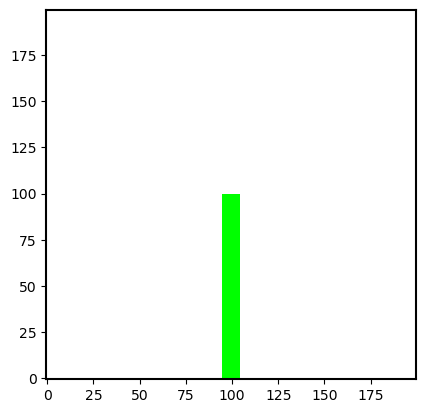

In [25]:
#Creating a image
colors = np.ones((200,200,3))
colors[:100,95:105,(0,2)] = 0
plt.imshow(colors)

In [35]:
ioImage = io.imread("/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0590-.tiff")
hist = PIL.Image.open("/Users/fanjx1/Documents/SandImages/Composites/SiliconCarbide-Dry/0590-.tiff").histogram()
df = pd.DataFrame(hist, list(range(256)))
display(ioImage)
display(df)

array([[ 62,  68,  64, ...,  89,  97, 107],
       [ 66,  65,  67, ..., 157, 160, 135],
       [ 69,  69,  75, ..., 221, 220, 210],
       ...,
       [253, 254, 208, ...,  23,  33,  25],
       [182, 254, 254, ...,  27,  37,  32],
       [253, 253, 253, ...,  28,  25,  28]], dtype=uint8)

0
0       27
1      101
2      547
3     2254
4     5891
..     ...
251   1553
252   2270
253  11722
254  96140
255  35218

[256 rows x 1 columns]